In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')
! ln -s drive/MyDrive/CV-Project/dataset ./dataset
! pip install -U -q opencv-python
! pip install -q open3d
! pip install -q pykitti
! pip install -q plotly
! pip install -q evo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link './dataset/dataset': File exists


#### PAUSE! MUST RESTART RUNTIME AFTER THE ABOVE PIP INSTALLS BEFORE PROCEEDING FURTHER
---



# Imports and Functions

In [ ]:
import sys
import cv2
import open3d
import pykitti
import evo
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from typing import *
from google.colab.patches import cv2_imshow


def getORB(im0: np.ndarray, im1: np.ndarray, coeff=0.8, nfeatures=None, getMatch=False):
    if nfeatures is not None:
        detector = cv2.ORB_create(nfeatures=nfeatures)
    else:
        detector = cv2.ORB_create()
    kp0, des0 = detector.detectAndCompute(im0, None)
    kp1, des1 = detector.detectAndCompute(im1, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    pts0 = []
    pts1 = []
    match = []
    for m, n in bf.knnMatch(des0, des1, k=2):
        if m.distance < coeff*n.distance:
            pts0.append(kp0[m.queryIdx].pt)
            pts1.append(kp1[m.trainIdx].pt)
            if getMatch:
                match.append(m)
    if getMatch:
        return np.array(pts0), kp0, np.array(pts1), kp1, match
    return np.array(pts0), kp0, np.array(pts1), kp1


def getSIFT(im0: np.ndarray, im1: np.ndarray, coeff=0.8, nfeatures=None, getMatch=False):
    if nfeatures is not None:
        detector = cv2.SIFT_create(nfeatures=nfeatures)
    else:
        detector = cv2.SIFT_create()
    detector = cv2.SIFT_create(nfeatures=nfeatures)
    kp0, des0 = detector.detectAndCompute(im0, None)
    kp1, des1 = detector.detectAndCompute(im1, None)

    bf = cv2.BFMatcher(cv2.NORM_L2)
    pts0 = []
    pts1 = []
    match = []
    for m, n in bf.knnMatch(des0, des1, k=2):
        if m.distance < coeff*n.distance:
            pts0.append(kp0[m.queryIdx].pt)
            pts1.append(kp1[m.trainIdx].pt)
            if getMatch:
                match.append(m)
    if getMatch:
        return np.array(pts0), kp0, np.array(pts1), kp1, match
    return np.array(pts0), kp0, np.array(pts1), kp1


def writeKitti(poses: List[np.ndarray], filename='stereoVO.txt'):
    with open(filename, 'w') as f:
        for p in poses:
            f.write(f"{' '.join(map(str, p[:3].reshape(-1)))}\n")



def plotPath(estPath, truPath, segments=6):
    for i in range(segments):
        j = int(len(estPath) * (i+1) / segments)
        print(f'{j} Points')
        plt.plot(*zip(*map(lambda x: (x[0, 3], x[2, 3]), estPath[:j])), 'go', label='estimate')
        plt.plot(*zip(*map(lambda x: (x[0, 3], x[2, 3]), truPath[:j])), 'ro', label='ground-truth')
        plt.legend()
        plt.show()



dataset = pykitti.odometry('./dataset', '00')
print('calib cam0 intrinsic calibration\n', dataset.calib.K_cam0, '\n')
print('calib cam1 intrinsic calibration\n', dataset.calib.K_cam1, '\n')
print('calib baseline (meters)\n', dataset.calib.b_gray, '\n')
print('calib cam0 projection\n', dataset.calib.P_rect_00, '\n')
print('calib cam1 projection\n', dataset.calib.P_rect_10, '\n')

calib cam0 intrinsic calibration
 [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

calib cam1 intrinsic calibration
 [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

calib baseline (meters)
 0.5371657081270053 

calib cam0 projection
 [[718.856    0.     607.1928   0.    ]
 [  0.     718.856  185.2157   0.    ]
 [  0.       0.       1.       0.    ]] 

calib cam1 projection
 [[ 718.856     0.      607.1928 -386.1448]
 [   0.      718.856   185.2157    0.    ]
 [   0.        0.        1.        0.    ]] 



# Monocular VO

In [ ]:
# Initialize gray sequence and pose
currPose = np.hstack((np.eye(3), np.zeros((3, 1))))
grTrPose = iter(dataset.poses)
grImg = iter(dataset.gray)
K = dataset.calib.K_cam0

path = [currPose]

img1 = np.array(next(grImg)[0])
gt1 = next(grTrPose)[:3, 3]

In [ ]:
# Ok to end mid-run and restart mid-run
# By ending and restarting this cell
while True:
    print(f'Path Points: {len(path)}')
    img0 = img1
    try:
        img1 = np.array(next(grImg)[0])
    except StopIteration:
        break
    
    gt0 = gt1
    gt1 = next(grTrPose)[:3, 3]

    pts0, kp0, pts1, kp1 = getSIFT(img0, img1, coeff=0.8, nfeatures=600)
    # pts0, kp0, pts1, kp1 = getORB(img0, img1, coeff=0.5)                         # Generally worse than SIFT
    E, inliers = cv2.findEssentialMat(pts1, pts0, K, cv2.RANSAC, prob=0.9999, threshold=0.25)  # RANSAC bad when threshold is too tight
    _, R, t, inliers = cv2.recoverPose(E, pts1, pts0, K, mask=inliers)

    tScale = np.linalg.norm(gt1) / np.linalg.norm(gt0)
    if tScale > 10:
        tScale = 1

    T = np.vstack(( np.hstack((R, t * tScale)), np.array([0, 0, 0, 1]) ))
    currPose = currPose @ T
    path.append(currPose)


writeKitti(path, 'monoVO.txt')
! mv monovoDH1.txt drive/MyDrive/CV-Project/monoVO.txt      # Save results

Path Points: 1
Path Points: 2
Path Points: 3
Path Points: 4
Path Points: 5
Path Points: 6
Path Points: 7
Path Points: 8
Path Points: 9
Path Points: 10
Path Points: 11
Path Points: 12
Path Points: 13
Path Points: 14
Path Points: 15
Path Points: 16
Path Points: 17
Path Points: 18
Path Points: 19
Path Points: 20
Path Points: 21
Path Points: 22
Path Points: 23
Path Points: 24
Path Points: 25
Path Points: 26
Path Points: 27
Path Points: 28
Path Points: 29
Path Points: 30
Path Points: 31
Path Points: 32
Path Points: 33
Path Points: 34
Path Points: 35
Path Points: 36
Path Points: 37
Path Points: 38
Path Points: 39
Path Points: 40
Path Points: 41
Path Points: 42
Path Points: 43
Path Points: 44
Path Points: 45
Path Points: 46
Path Points: 47
Path Points: 48
Path Points: 49
Path Points: 50
Path Points: 51
Path Points: 52
Path Points: 53
Path Points: 54
Path Points: 55
Path Points: 56
Path Points: 57
Path Points: 58
Path Points: 59
Path Points: 60
Path Points: 61
Path Points: 62
Path Points: 63


KeyboardInterrupt: ignored

21 Points


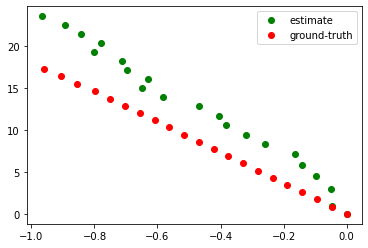

42 Points


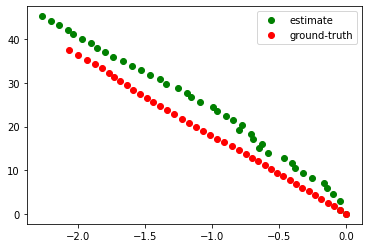

63 Points


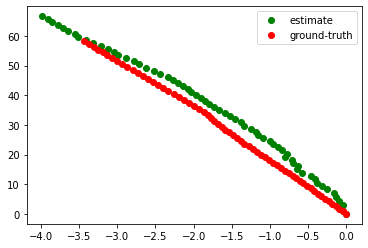

In [ ]:
plotPath(path, dataset.poses, segments=3)